In [191]:
import pandas as pd 
import matplotlib 
import numpy as np 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

### Data Load

In [192]:
circuits = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/circuits.csv')
laptimes = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/lap_times.csv')
pitstops = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/pit_stops.csv')
seasons = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/seasons.csv')
status = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/status.csv')
constructor_standings = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/constructor_standings.csv')
constructors = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/constructors.csv')
driver_standings = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/driver_standings.csv')
drivers = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/drivers.csv')
races = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/races.csv')
constructor_results = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/constructor_results.csv')
results = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/results.csv')
qualifying = pd.read_csv('../Group_3_Project-main/F1 CSV Datasets/qualifying.csv')
# pd.get_option("display.max_columns",None)

In [193]:
results.head(5)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [194]:
results.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

In [195]:
results.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId
count,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000
mean,13041.372661,536.695667,266.277569,49.059663,11.167561,12.854141,1.906635,46.076687,17.476074
std,7530.008377,303.034639,272.581622,60.221056,7.232797,7.700068,4.219715,29.726058,26.129965
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,6520.750000,294.750000,57.000000,6.000000,5.000000,6.000000,0.000000,22.000000,1.000000
50%,13040.500000,519.000000,163.000000,25.000000,11.000000,12.000000,0.000000,53.000000,10.000000
75%,19560.250000,791.000000,364.000000,58.250000,17.000000,18.000000,2.000000,66.000000,14.000000
max,26085.000000,1110.000000,858.000000,214.000000,34.000000,39.000000,50.000000,200.000000,141.000000


In [196]:
results.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')

In [197]:
results.isna().sum()

resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
time               0
milliseconds       0
fastestLap         0
rank               0
fastestLapTime     0
fastestLapSpeed    0
statusId           0
dtype: int64

In [198]:
# .get_option("display.max_columns",None)
races = races.rename(columns={'name': 'racename'})

# Merge the DataFrames
HW = pd.merge(results, races[['raceId', 'year', 'racename', 'round', 'date']], on='raceId', how='left')
HW = pd.merge(HW, drivers[['driverId', 'driverRef', 'forename', 'surname', 'nationality', 'dob']], on='driverId', how='left')
HW = pd.merge(HW, constructors[['constructorId', 'name', 'nationality']], on='constructorId', how='left')
HW = pd.merge(HW, status[['statusId', 'status']], on='statusId', how='left')

# Set display option to show all columns
pd.set_option("display.max_columns", None)

In [199]:
HW.groupby('racename')['raceId'].nunique().sum()

1091

In [200]:
# Getting a count of races from 1950 - 2023 and sorted in descending and fitered to top 5 Races 
races = HW.groupby('racename')['raceId'].nunique().reset_index(name='# Races').sort_values(by='# Races', ascending=False)
_numRaces = races.head(5)
_numRaces

,racename,# Races
9,British Grand Prix,74
24,Italian Grand Prix,73
32,Monaco Grand Prix,69
7,Belgian Grand Prix,68
20,German Grand Prix,64


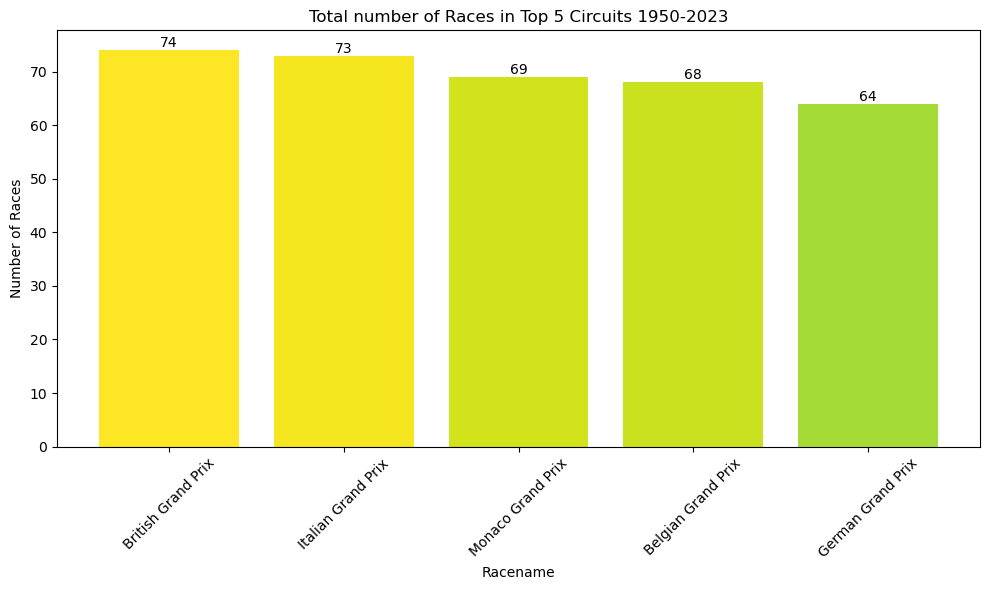

In [201]:
# Get the values for coloring
values = _numRaces['# Races']

# Creating a color gradient based on the values
colors = plt.cm.viridis(values / float(max(values)))  # Using viridis colormap

# Plotting the bar chart with gradient colors
plt.figure(figsize=(10, 6))
bars = plt.bar(_numRaces['racename'], _numRaces['# Races'], color=colors)
plt.xlabel('Racename')
plt.ylabel('Number of Races')
plt.title('Total number of Races in Top 5 Circuits 1950-2023')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding data labels to each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

# Show plot
plt.show()

In [202]:
# defining a list of top 5 races to be passed on to filter dataframe.
racename_list = ['British Grand Prix',
              'Italian Grand Prix',
              'Monaco Grand Prix',
              'Belgian Grand Prix',
              'German Grand Prix']

In [203]:
# filtering the dataframne to Top 5 Race Circuits
filtered_df = HW[(HW['racename'].isin(racename_list))]

In [204]:
# filtered the dataframe by the StatusId = 3,4 i.e collisions and accidents and top 5 races.
accidents_top5 = filtered_df[(filtered_df['statusId'].isin([3, 4]))]
accidents_top5.head(2)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,racename,round,date,driverRef,forename,surname,nationality_x,dob,name,nationality_y,status
122,123,23,16,10,20,18,\N,R,15,0.0,67,\N,\N,60,16,1:22.039,146.564,4,2008,Monaco Grand Prix,6,2008-05-25,sutil,Adrian,Sutil,German,1983-01-11,Force India,Indian,Collision
123,124,23,3,3,7,6,\N,R,16,0.0,59,\N,\N,58,15,1:21.270,147.951,3,2008,Monaco Grand Prix,6,2008-05-25,rosberg,Nico,Rosberg,German,1985-06-27,Williams,British,Accident


In [205]:
accidents_top5.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'racename', 'round', 'date',
       'driverRef', 'forename', 'surname', 'nationality_x', 'dob', 'name',
       'nationality_y', 'status'],
      dtype='object')

In [206]:
# Grouping by 'racename' column and getting a count of the collisions and accidents.
_numAccidents = accidents_top5.groupby('racename')['raceId'].count().reset_index(name='Accidents/collisions').sort_values(by='Accidents/collisions', ascending=False)


In [207]:
_numAccidents.head(5)

,racename,Accidents/collisions
4,Monaco Grand Prix,191
0,Belgian Grand Prix,144
2,German Grand Prix,115
1,British Grand Prix,109
3,Italian Grand Prix,94


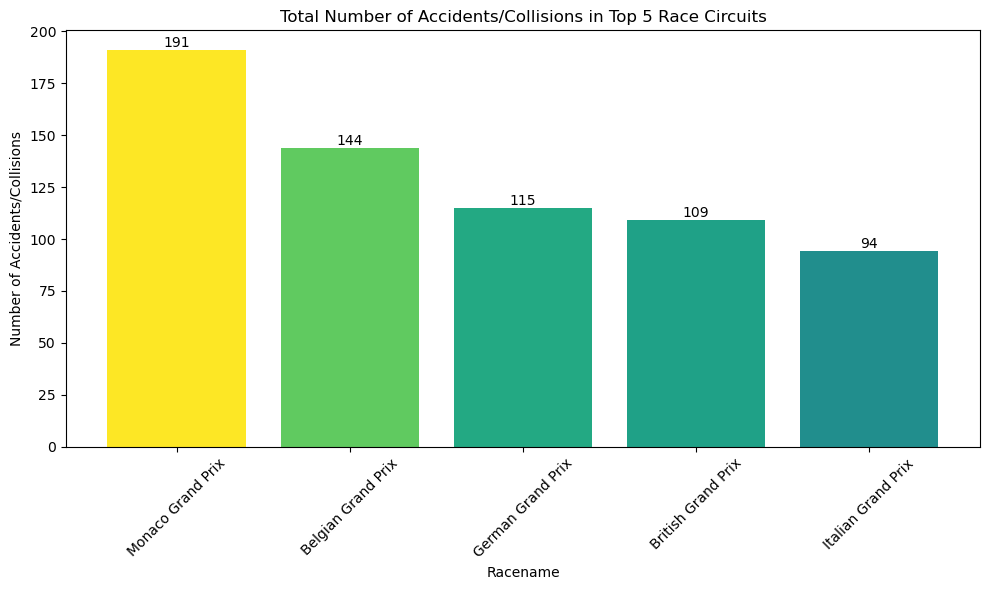

In [208]:
# Get the values for coloring
values = _numAccidents['Accidents/collisions']

# Creating a color gradient based on the values
colors = plt.cm.viridis(values / float(max(values)))  # Using viridis colormap

# Plotting the bar chart with gradient colors
plt.figure(figsize=(10, 6))
bars = plt.bar(_numAccidents['racename'], _numAccidents['Accidents/collisions'], color=colors)
plt.xlabel('Racename')
plt.ylabel('Number of Accidents/Collisions')
plt.title('Total Number of Accidents/Collisions in Top 5 Race Circuits')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding data labels to each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

# Show plot
plt.show()

In [209]:
# Total number of races by the top 5 constructors who participated in the top 5 races.
_numRaces_byConst_top5 = filtered_df.groupby('name')['raceId'].nunique().reset_index(name='# Races').sort_values(by='# Races', ascending=False).head(5)
_numRaces_byConst_top5


,name,# Races
60,Ferrari,342
111,McLaren,254
164,Williams,224
160,Tyrrell,138
152,Team Lotus,132


In [210]:
# Grouping by 'Constructor name' column and summing up the values
_numAccidents_byConst_top5 = accidents_top5.groupby('name')['raceId'].nunique().reset_index(name='# Accidents/Collisions').sort_values(by='# Accidents/Collisions', ascending=False).head(5)
_numAccidents_byConst_top5

,name,# Accidents/Collisions
25,Ferrari,58
52,McLaren,48
86,Williams,33
68,Sauber,29
84,Tyrrell,22


In [211]:
# Merge the DataFrames on the 'name' column
merged_df = pd.merge(_numAccidents_byConst_top5, _numRaces_byConst_top5, on='name')

# Calculate the ratio of accidents to races for the top 5 constructors
merged_df['Accidents-to-Races Ratio'] = np.round((merged_df['# Accidents/Collisions'] / merged_df['# Races'])*100, 1)

In [212]:
merged_df

,name,# Accidents/Collisions,# Races,Accidents-to-Races Ratio
0,Ferrari,58,342,17.0
1,McLaren,48,254,18.9
2,Williams,33,224,14.7
3,Tyrrell,22,138,15.9


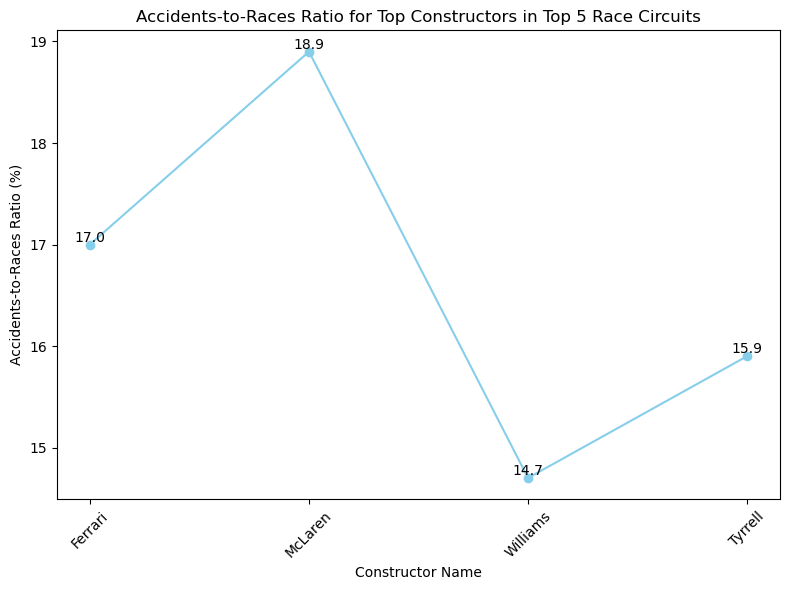

In [213]:
# Plotting the line plot
plt.figure(figsize=(8, 6))
plt.plot(merged_df['name'], merged_df['Accidents-to-Races Ratio'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Constructor Name')
plt.ylabel('Accidents-to-Races Ratio (%)')
plt.title('Accidents-to-Races Ratio for Top Constructors in Top 5 Race Circuits')
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
# Adding data labels to each data point
for i, txt in enumerate(merged_df['Accidents-to-Races Ratio']):
    plt.text(i, txt, f'{txt}', ha='center', va='bottom')

# Show plot
plt.show()

In [214]:
# Grouping by 'Status' column and summing up the values
status_summary = accidents_top5.groupby('status')['raceId'].nunique().reset_index(name='Sum')

In [215]:
status_summary

,status,Sum
0,Accident,162
1,Collision,105


In [216]:
accidents_top5.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'racename', 'round', 'date',
       'driverRef', 'forename', 'surname', 'nationality_x', 'dob', 'name',
       'nationality_y', 'status'],
      dtype='object')

In [217]:
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score

In [218]:
temp_df = HW[(HW['statusId'].isin([3, 4]))]

In [219]:
# # Getting a count of races from 1950 - 2023 and sorted in descending and fitered to top 5 Races 
# races_year = temp_df.groupby('year')['raceId'].nunique().reset_index(name='# Races').sort_values(by='year', ascending=True)
# # _numRaces = races.head(5)
# # races_year = races_year.sort_values(by = 'year')
# races_year

In [220]:
# Getting a count of races from 1950 - 2023 and sorted in descending and fitered to top 5 Races 
accidents_year = temp_df.groupby('year')['status'].count().reset_index(name='# Accidents').sort_values(by='year', ascending=True)
# _numRaces = races.head(5)
# races_year = races_year.sort_values(by = 'year')
accidents_year

,year,# Accidents
0,1950,13
1,1951,9
2,1952,5
3,1953,13
4,1954,13
...,...,...
69,2019,21
70,2020,18
71,2021,26
72,2022,18


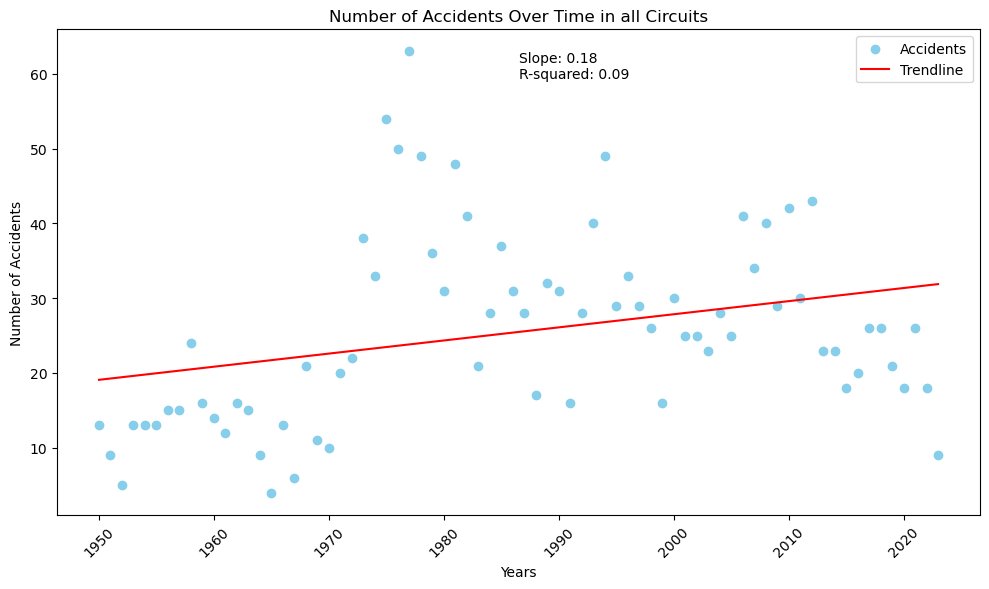

In [221]:
# Plotting the number of accidents over time with a trendline
plt.figure(figsize=(10, 6))
plt.scatter(accidents_year['year'], accidents_year['# Accidents'], color='skyblue', label='Accidents')
plt.xlabel('Years')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over Time in all Circuits')

# Calculate the trendline using polynomial regression (adjust the degree as needed)
degree = 1  # Linear regression
p = np.polyfit(accidents_year['year'], accidents_year['# Accidents'], degree)
trendline = np.polyval(p, accidents_year['year'])

# Plotting the trendline
plt.plot(accidents_year['year'], trendline, color='red', label='Trendline')

# Calculate slope and R-squared (R2) value
slope, intercept = p
r2_value = r2_score(accidents_year['# Accidents'], trendline)

# Display slope and R2 value on the plot
plt.text(0.5, 0.9, f'Slope: {slope:.2f}\nR-squared: {r2_value:.2f}', transform=plt.gca().transAxes, fontsize=10)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [222]:
# filtering the dataframne to Top 5 Race Circuits
filtered_temp = temp_df[(temp_df['racename'].isin(racename_list))]

In [223]:
# Getting a count of races from 1950 - 2023 and sorted in descending and fitered to top 5 Races 
accidents_year_top5 = filtered_temp.groupby('year')['status'].count().reset_index(name='# Accidents').sort_values(by='year', ascending=True)
# _numRaces = races.head(5)
# races_year = races_year.sort_values(by = 'year')
# accidents_year_top5

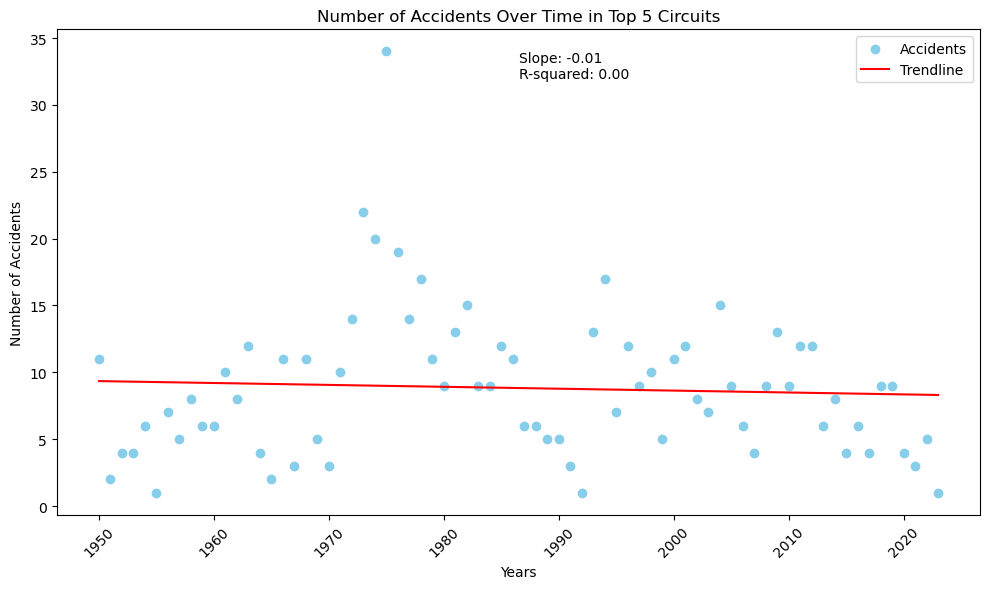

In [224]:
# Plotting the number of accidents over time with a trendline
plt.figure(figsize=(10, 6))
plt.scatter(accidents_year_top5['year'], accidents_year_top5["# Accidents"], color='skyblue', label='Accidents')
plt.xlabel('Years')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over Time in Top 5 Circuits')

# Calculate the trendline using polynomial regression (adjust the degree as needed)
degree = 1  # Linear regression
p = np.polyfit(accidents_year_top5['year'], accidents_year_top5["# Accidents"], degree)
trendline = np.polyval(p, accidents_year_top5['year'])

# Plotting the trendline
plt.plot(accidents_year_top5['year'], trendline, color='red', label='Trendline')

# Calculate slope and R-squared (R2) value
slope, intercept = p
r2_value = r2_score(accidents_year_top5["# Accidents"], trendline)

# Display slope and R2 value on the plot
plt.text(0.5, 0.9, f'Slope: {slope:.2f}\nR-squared: {r2_value:.2f}', transform=plt.gca().transAxes, fontsize=10)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()